In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import numpy as np
import os
from PIL import Image
import cv2
import joblib  

SIZE = 224

base_dir = "stamp_data"
fake_dir = os.path.join(base_dir, "fake")
real_dir = os.path.join(base_dir, "real")

# Lists to store real and fake images
real_images = []
fake_images = []

def is_image(filename):
    try:
        with Image.open(filename) as img:
            img.verify()  
        return True
    except (IOError, OSError) as e:
        return False

for filename in os.listdir(fake_dir)[:100]: 
    img_path = os.path.join(fake_dir, filename)
    if is_image(img_path):
        try:
            img = Image.open(img_path).convert('L')  
            img = np.array(img)
            img = cv2.resize(img, (SIZE, SIZE))
            fake_images.append(img)
        except Exception as e:
            print(f"Skipping non-image file: {img_path}, Error: {e}")

for filename in os.listdir(real_dir)[:100]: 
    img_path = os.path.join(real_dir, filename)
    if is_image(img_path):
        try:
            img = Image.open(img_path).convert('L') 
            img = np.array(img)
            img = cv2.resize(img, (SIZE, SIZE))
            real_images.append(img)
        except Exception as e:
            print(f"Skipping non-image file: {img_path}, Error: {e}")

# onvert the lists of images into NumPy arrays 
real_images = np.array(real_images)
fake_images = np.array(fake_images)

#Create labels , respectively, where 0 represents real stamps and 1 represents fake stamps. 
real_labels = np.zeros((real_images.shape[0], 1))
fake_labels = np.ones((fake_images.shape[0], 1))
images = np.concatenate((real_images, fake_images))
labels = np.concatenate((real_labels, fake_labels))
images = images.reshape(images.shape[0], -1)

train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


In [15]:

smote = SMOTE(random_state=42)
train_data, train_labels = smote.fit_resample(train_data, train_labels)

param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear'], 
    'gamma': ['scale'] 
}

grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=2)  # Using fewer folds for faster processing
grid_search.fit(train_data, train_labels.ravel())

print("Best Parameters:", grid_search.best_params_)

best_estimator = grid_search.best_estimator_
predictions_svm = best_estimator.predict(test_data)

report = classification_report(test_labels, predictions_svm)
print("Classification Report:\n", report)




Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.57      0.69        21
         1.0       0.65      0.89      0.76        19

    accuracy                           0.72        40
   macro avg       0.76      0.73      0.72        40
weighted avg       0.76      0.72      0.72        40



In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# KNN Model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_data, train_labels.ravel())  # Ensure labels are in the correct shape by using ravel()

predictions_knn = knn.predict(test_data)

report_knn = classification_report(test_labels, predictions_knn)
print("KNN Classification Report:\n", report_knn)

accuracy_knn = accuracy_score(test_labels, predictions_knn)
print("KNN Accuracy:", accuracy_knn)


KNN Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.24      0.37        21
         1.0       0.53      0.95      0.68        19

    accuracy                           0.57        40
   macro avg       0.68      0.59      0.52        40
weighted avg       0.69      0.57      0.52        40

KNN Accuracy: 0.575


In [7]:
from skimage.feature import hog
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import numpy as np

SIZE = 224  # Assuming SIZE is defined as before for image reshaping

# Assume `images` and `labels` are defined as before in your earlier part of the code

hog_features = []
for image in images:
    fd = hog(image.reshape(SIZE, SIZE), orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), feature_vector=True)
    hog_features.append(fd)
hog_features = np.array(hog_features)

train_data_hog, test_data_hog, train_labels_hog, test_labels_hog = train_test_split(
    hog_features, labels, test_size=0.2, random_state=42)

scaler_hog = StandardScaler()
train_data_hog_scaled = scaler_hog.fit_transform(train_data_hog)
test_data_hog_scaled = scaler_hog.transform(test_data_hog)

smote = SMOTE(random_state=42)
train_data_resampled, train_labels_resampled = smote.fit_resample(train_data_hog_scaled, train_labels_hog.ravel())

knn_hog = KNeighborsClassifier(n_neighbors=3)
knn_hog.fit(train_data_resampled, train_labels_resampled.ravel())

predictions_knn_hog = knn_hog.predict(test_data_hog_scaled)

report_knn_hog = classification_report(test_labels_hog, predictions_knn_hog)
print("KNN with HOG Features Classification Report:\n", report_knn_hog)

accuracy_knn_hog = accuracy_score(test_labels_hog, predictions_knn_hog)
print("Accuracy of KNN with HOG Features:", accuracy_knn_hog)


KNN with HOG Features Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.76      0.73        21
         1.0       0.71      0.63      0.67        19

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.70        40
weighted avg       0.70      0.70      0.70        40

Accuracy of KNN with HOG Features: 0.7


In [10]:
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import numpy as np

images = [image.reshape(224, 224) for image in images]  # Reshape images to 224x224 if they are square

print("Shape of first reshaped image:", images[0].shape)

hog_features = []
for image in images:
    # Adjust HOG parameters if needed
    fd = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), feature_vector=True)
    hog_features.append(fd)

hog_features = np.array(hog_features)
print("Shape of HOG features after reshaping:", hog_features.shape)

if hog_features.size == 0:
    print("Error: No features extracted. Check the image input and HOG parameters.")
else:
    # Continue with the rest of the processing
    train_data, test_data, train_labels, test_labels = train_test_split(hog_features, labels, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    train_data_scaled = scaler.fit_transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    smote = SMOTE(random_state=42)
    train_data_resampled, train_labels_resampled = smote.fit_resample(train_data_scaled, train_labels)

    svm_classifier_hog = SVC(class_weight='balanced', kernel='linear', gamma='scale')
    svm_classifier_hog.fit(train_data_resampled, train_labels_resampled)

    predictions_svm_hog = svm_classifier_hog.predict(test_data_scaled)

    report_svm_hog = classification_report(test_labels, predictions_svm_hog)
    print("SVM with HOG Features Classification Report:\n", report_svm_hog)


Shape of first reshaped image: (224, 224)
Shape of HOG features after reshaping: (199, 1568)
SVM with HOG Features Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.57      0.67        21
         1.0       0.64      0.84      0.73        19

    accuracy                           0.70        40
   macro avg       0.72      0.71      0.70        40
weighted avg       0.72      0.70      0.70        40



In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_classifier_hog = SVC(class_weight='balanced')
grid_search = GridSearchCV(svm_classifier_hog, param_grid, cv=5)
grid_search.fit(train_data_resampled, train_labels_resampled)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_svm_classifier_hog = grid_search.best_estimator_
predictions_svm_hog = best_svm_classifier_hog.predict(test_data_hog_scaled)

report_svm_hog = classification_report(test_labels_hog, predictions_svm_hog)
print("SVM with HOG Features Classification Report (after optimization):\n", report_svm_hog)

Best Hyperparameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM with HOG Features Classification Report (after optimization):
               precision    recall  f1-score   support

         0.0       0.86      0.57      0.69        21
         1.0       0.65      0.89      0.76        19

    accuracy                           0.72        40
   macro avg       0.76      0.73      0.72        40
weighted avg       0.76      0.72      0.72        40



In [12]:
from sklearn.ensemble import VotingClassifier

svm_classifier = SVC(class_weight='balanced', kernel='linear', gamma='scale')
knn_classifier = KNeighborsClassifier(n_neighbors=3)
estimators = [('svm', svm_classifier), ('knn', knn_classifier)]

voting_classifier = VotingClassifier(estimators, voting='hard')
voting_classifier.fit(train_data, train_labels.ravel())

predictions_voting = voting_classifier.predict(test_data)

report_voting = classification_report(test_labels, predictions_voting)
print("Voting Classifier Classification Report:\n", report_voting)


Voting Classifier Classification Report:
               precision    recall  f1-score   support

         0.0       0.64      0.76      0.70        21
         1.0       0.67      0.53      0.59        19

    accuracy                           0.65        40
   macro avg       0.65      0.64      0.64        40
weighted avg       0.65      0.65      0.64        40



In [13]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(train_data, train_labels.ravel())

predictions_rf = random_forest.predict(test_data)

report_rf = classification_report(test_labels, predictions_rf)
print("Random Forest Classification Report:\n", report_rf)


Random Forest Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.62      0.68        21
         1.0       0.65      0.79      0.71        19

    accuracy                           0.70        40
   macro avg       0.71      0.70      0.70        40
weighted avg       0.71      0.70      0.70        40



In [3]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

smote = SMOTE(random_state=42)
train_data_resampled, train_labels_resampled = smote.fit_resample(train_data, train_labels.ravel())  # .ravel() to change shape from (n, 1) to (n,)

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # binary classification
    eval_metric='logloss',        # metric to be used
    use_label_encoder=False       # as we're providing labels directly
)

param_grid = {
    'max_depth': [3, 6],                # depth of trees
    'n_estimators': [50, 100, 150],     # number of trees
    'learning_rate': [0.01, 0.1, 0.2]   # step size shrinkage used to prevent overfitting
}

grid_search = GridSearchCV(xgb_model, param_grid, cv=3, verbose=1)  # Use 3-fold cross-validation
grid_search.fit(train_data_resampled, train_labels_resampled)

print("Best Parameters:", grid_search.best_params_)
#Best Parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}
best_xgb_model = grid_search.best_estimator_

predictions = best_xgb_model.predict(test_data)

report = classification_report(test_labels, predictions)
print("Classification Report:\n", report)



Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 6, 'n_estimators': 100}
Classification Report:
               precision    recall  f1-score   support

         0.0       0.92      0.57      0.71        21
         1.0       0.67      0.95      0.78        19

    accuracy                           0.75        40
   macro avg       0.79      0.76      0.74        40
weighted avg       0.80      0.75      0.74        40



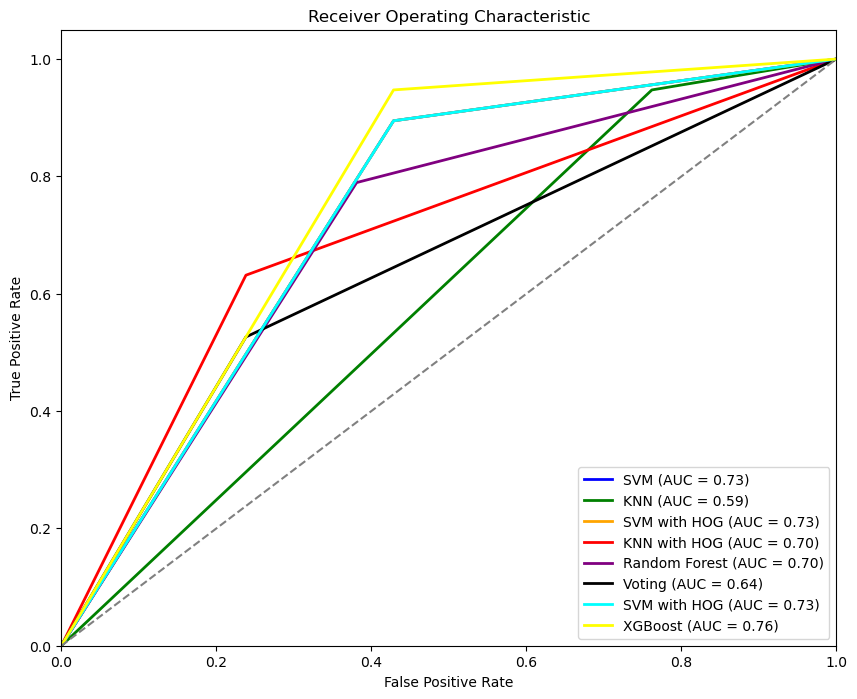

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_svm, tpr_svm, _ = roc_curve(test_labels, predictions_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_knn, tpr_knn, _ = roc_curve(test_labels, predictions_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_knn_hog, tpr_knn_hog, _ = roc_curve(test_labels_hog, predictions_knn_hog)
roc_auc_knn_hog = auc(fpr_knn_hog, tpr_knn_hog)

fpr_svm_hog, tpr_svm_hog, _ = roc_curve(test_labels_hog, predictions_svm_hog)
roc_auc_svm_hog = auc(fpr_svm_hog, tpr_svm_hog)

fpr_voting, tpr_voting, _ = roc_curve(test_labels, predictions_voting)
roc_auc_voting = auc(fpr_voting, tpr_voting)

fpr_rf, tpr_rf, _ = roc_curve(test_labels, predictions_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_svm_hog, tpr_svm_hog, _ = roc_curve(test_labels_hog, predictions_svm_hog)
roc_auc_svm_hog = auc(fpr_svm_hog, tpr_svm_hog)

fpr_xgb, tpr_xgb, _ = roc_curve(test_labels, predictions)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plot ROC curves for all classifiers
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label='SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot(fpr_knn, tpr_knn, color='green', lw=2, label='KNN (AUC = %0.2f)' % roc_auc_knn)
plt.plot(fpr_svm_hog, tpr_svm_hog, color='orange', lw=2, label='SVM with HOG (AUC = %0.2f)' % roc_auc_svm_hog)
plt.plot(fpr_knn_hog, tpr_knn_hog, color='red', lw=2, label='KNN with HOG (AUC = %0.2f)' % roc_auc_knn_hog)
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)
plt.plot(fpr_voting, tpr_voting, color='black', lw=2, label='Voting (AUC = %0.2f)' % roc_auc_voting)
plt.plot(fpr_svm_hog, tpr_svm_hog, color='cyan', lw=2, label='SVM with HOG (AUC = %0.2f)' % roc_auc_svm_hog)
plt.plot(fpr_xgb, tpr_xgb, color='yellow', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [20]:

joblib.dump(best_xgb_model, 'stamp_best_xgb_model.joblib')


['stamp_best_xgb_model.joblib']